In [92]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = pops*(Psun<3.0)
weights /= sum(weights)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

In [93]:
# Figure setup
from mpl_toolkits.basemap import shiftgrid


# Set up binning
n = 100
ph = flipud(linspace(-pi, pi-2*pi/n, n))
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1
        
def convertmap(fv3D):
    fv_map = zeros(shape=(n/2,n))
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    return fv_map



# v binning
nv = 1000
v_vals = linspace(0.1,600,nv)

# Smooth
fv3D_Saus = zeros(shape=n*n/2)
fv3D_Iso = zeros(shape=n*n/2)
for j in range(0,nv):
    fv3D_Iso += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_iso)
    fv3D_Saus += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_beta)
fv_map_Saus = convertmap(fv3D_Saus)
fv_map_Iso = convertmap(fv3D_Iso)
    
# Shards
fv_map_shards = zeros(shape=(n/2,n,nshards))
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    x_str = v_str/sqrt(sum(v_str**2.0))
    sig_s = dispersions[isub,:]
    fv3D = zeros(shape=(n*n/2))
    for j in range(0,nv):
        fv3D += v_vals[j]*weights[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_str)
    print isub
    fv_map_shards[:,:,isub] = convertmap(fv3D)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


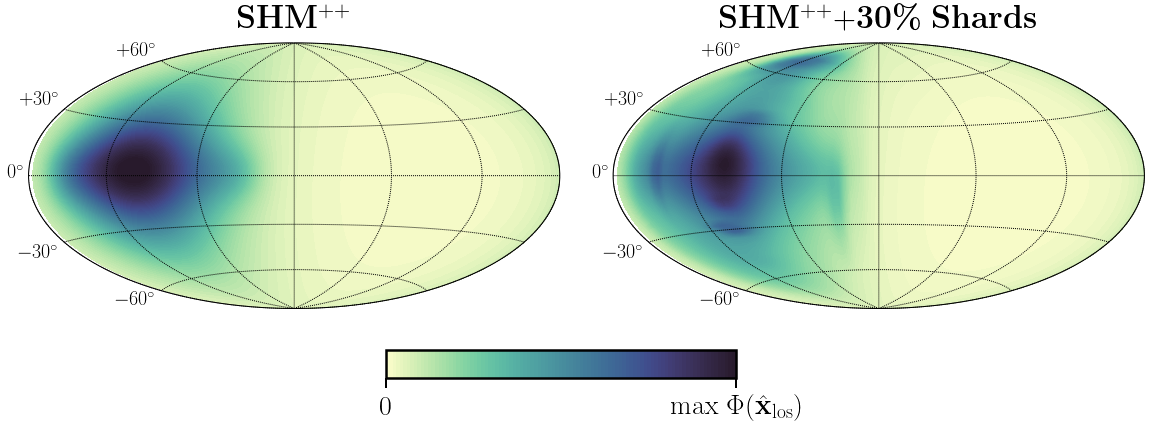

In [94]:
from IPython.display import clear_output
import matplotlib.gridspec as gridspec


plt.rcParams['axes.linewidth'] = 2.5
    
    
fig, axarr = plt.subplots(1, 2,figsize=(20,10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

import cmocean
cmap = cmocean.cm.deep

eta = 0.2
xi = 0.3
fv0 = (1-eta)*fv_map_Iso + eta*fv_map_Saus
fv_tot = (1-xi)*fv0 + xi*sum(fv_map_shards,2)

vmax = amax(fv_tot)


plt.sca(ax1)
m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)

clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'{\bf SHM}$^{++}$',fontsize=32,y=1.03)

plt.sca(ax2)
m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)

clear_output()

col_ex = (cm.Reds(linspace(0,1,5)))

# levels = [0.9,1.0]
# # S1
# isub = 0
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True,label='S1')
# clear_output()

# # S2
# isub = 1
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True,label='S2')
# clear_output()

# isub = 2
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Rg1
# isub = 4
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Rg3
# isub = 6
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()
# isub = 7
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Cand14
# isub = 20
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()
# isub = 21
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'{\bf SHM}$^{++}$+{\bf 30\%} {\bf Shards}',fontsize=32,y=1.03)


# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax1, width="50%", height="7%", bbox_to_anchor=[200, -200, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,100),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_xticklabels(['0', r'max $\Phi(\hat{\mathbf{x}}_{\rm los})$'])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)



plt.show()
pltname = 'ShardsFlux'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [95]:
from WIMPFuncs import *


n = 100
ph = linspace(-pi, pi, n)
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 1
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber
eta = 0.2

# Radon transform and rate
dR_smooth = zeros(shape=(3,n*n/2))
dR_shards = zeros(shape=(3,n*n/2))
fhat0 = zeros(shape=(n*n/2))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR_smooth[ibin,:] += (1-eta)*diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)
        fhat_saus = fhat_Triaxial(v_min[ie],-1.0*q,day,sig_beta)
        dR_smooth[ibin,:] += eta*diffRecoilRate_SI(E_r[ie],fhat_saus,A,sigma_p,m_chi)
        
        fhat = zeros(shape=(n*n/2))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR_shards[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print 'bin =',ibin

    

# Convert list into Mollweide map
dR_map_smooth = zeros(shape=(n/2,n,3))
dR_map_shards = zeros(shape=(n/2,n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            dR_map_smooth[i,j,ibin] = dR_smooth[ibin,ii]
            dR_map_shards[i,j,ibin] = dR_shards[ibin,ii]
            ii = ii+1
    dR_map_smooth[:,:,ibin] = flipud(dR_map_smooth[:,:,ibin])     
    dR_map_shards[:,:,ibin] = flipud(dR_map_shards[:,:,ibin])  
    

bin = 0
bin = 1
bin = 2


In [96]:
qq = zeros(shape=(n/2,n,3))
ii = 0
for i in range(0,n/2):
    for j in range(0,n):
        qq[i,j,0] = q[ii,0]
        qq[i,j,1] = q[ii,1]
        qq[i,j,2] = q[ii,2]
        ii = ii+1

# Apply angular res.
sig_a = 10*pi/180.0
def angres(q0):
    gamma = q0[0]*qq[:,:,0]+q0[1]*qq[:,:,1]+q0[2]*qq[:,:,2]
    gamma[gamma>1] = 1.0
    gamma[gamma<-1] = -1.0
    gamma = arccos(gamma)
    return exp(-gamma**2.0/(2*sig_a**2.0))

def applyangres(dR_map):
    dR_map_s = zeros(shape=(n/2,n,3))
    for ibin in range(0,3):
        for i in range(0,n/2):
            for j in range(0,n):
                K = angres(squeeze(qq[i,j,:]))
                Knorm = trapz(flipud(trapz(K,ph,axis=1)),flipud(cos(th)))
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(cos(th)))/Knorm
    return dR_map_s
                
dR_map_smooth_s = applyangres(dR_map_smooth)
dR_map_shards_s = applyangres(dR_map_shards)

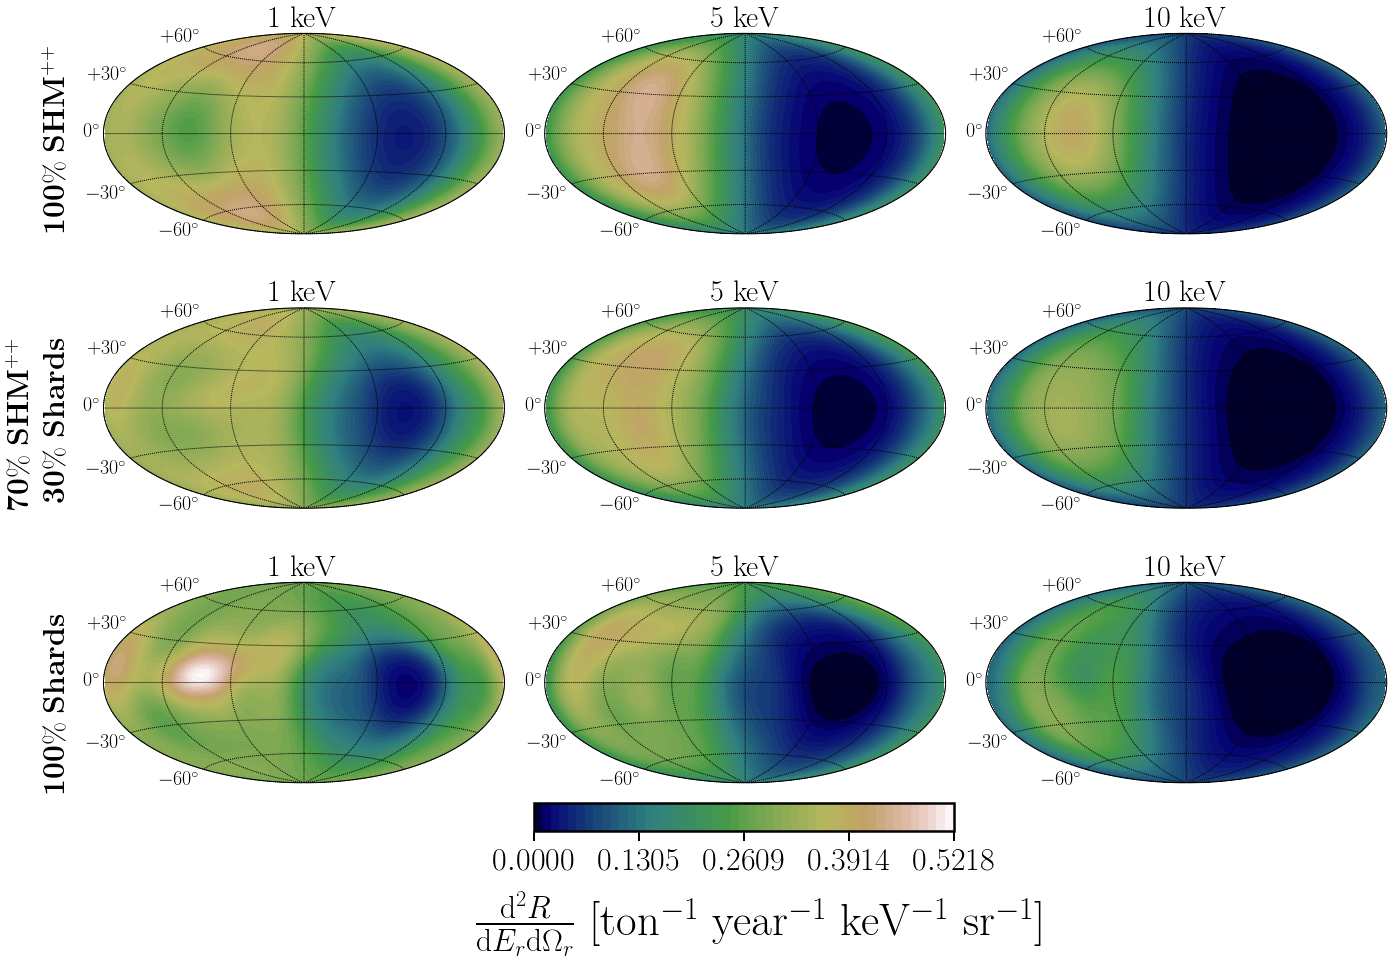

In [99]:
from IPython.display import clear_output
import matplotlib.gridspec as gridspec


# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axarr = plt.subplots(3, 3,figsize=(23,15))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1,hspace=0.03)


import cmocean
cmap = cm.gist_earth


tit = [r'$1$ keV',r'$5$ keV',r'$10$ keV']

xi = 0.35
dR2 = (1-xi)*dR_map_smooth_s+xi*dR_map_shards_s

vmin = amin(dR_map_shards_s)
vmax = amax(dR_map_shards_s)

ncons = 50

for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[0,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()


for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[1,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()

for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[2,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()

    
    
plt.sca(plt.subplot(gs[0,0]))
plt.annotate(r'{\bf 100}\% {\bf SHM}$^{++}$', xy=(-0.15, 0.85), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(plt.subplot(gs[1,0]))
plt.annotate(r'{\bf 70}\% {\bf SHM}$^{++}$', xy=(-0.24, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)
plt.annotate(r'{\bf 30}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(plt.subplot(gs[2,0]))
plt.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(plt.subplot(gs[2,1]), width="60%", height="7%", bbox_to_anchor=[370, -240, 700, 400]) 
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=linspace(vmin,vmax,5),boundaries=linspace(vmin,vmax,ncons),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.35,-0.004,r'$\frac{\mathrm{d}^2 R}{\mathrm{d}E_r \mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=45)
# save figure
plt.show()
pltname = 'Shards_Directional'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [100]:
from scipy.optimize import fmin


# FUNCTION MINIMISING METHOD 


def qhat(x):
    qhat = zeros(shape=(1,3))
    qhat[0,0] = sqrt(1-x[0]**2.0)*cos(x[1])
    qhat[0,1] = sqrt(1-x[0]**2.0)*sin(x[1])
    qhat[0,2] = x[0]
    return qhat


v_lab = LabVelocitySimple(day)
x_lab = -1.0*v_lab/sqrt(sum(v_lab**2.0))

m_chi = 50.0
sigma_p = 1.0e-45
A = F19.MassNumber

n_xi = 50
xi_vals = linspace(0,0.35,n_xi)

ne = 50
Evals = linspace(0.1,100.0,ne)
xmin0 = zeros(shape=(ne,2))
xmin_in = array([-0.05,4.4])
dth0 = zeros(shape=(ne))
for i in range(0,ne):
    v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
    def fhat0(x):
        return -1.0*fhat_Isotropic(v_min,qhat(x),day)
    if fhat0(xmin_in)==0.0:
        dth0[i] = 0.0
    else:
        res = fmin(fhat0,xmin_in,disp=False)
        xmin0[i,0] = res[0]
        xmin0[i,1] = res[1]
        xmin_in = xmin0[i,:]
        dth0[i] = 180/pi*arccos(sum(qhat(xmin_in)*x_lab))

xmin = zeros(shape=(ne,2,n_xi))
dth = zeros(shape=(ne,n_xi))
xmin_in = xmin0[0,:]
for j in range(0,n_xi):
    xi = xi_vals[j]
    for i in range(0,ne):
        if j==0:
            xmin_in = xmin0[i,:]
        else:
            xmin_in = xmin[i,:,j-1]
        
        v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
        def fhat(x):
            fhat = -1.0*(1-xi)*fhat_Isotropic(v_min,qhat(x),day)
            for k in range(0,nshards):
                v_s = velocities[k,:]
                sig_s = dispersions[k,:]
                fhat += -1.0*xi*weights[k]*fhat_Triaxial(v_min,qhat(x),day,sig_s,v_shift=v_s)
            return fhat
        if fhat(xmin_in)==0.0:
            dth[i,j] = 0.0
        else:
            res = fmin(fhat,xmin_in,disp=False)
            xmin[i,0,j] = res[0]
            xmin[i,1,j] = res[1]
            dth[i,j] = 180/pi*arccos(sum(qhat(xmin[i,:,j])*x_lab))
    print j,xi

0 0.0
1 0.00714285714286
2 0.0142857142857
3 0.0214285714286
4 0.0285714285714
5 0.0357142857143
6 0.0428571428571
7 0.05
8 0.0571428571429
9 0.0642857142857
10 0.0714285714286
11 0.0785714285714
12 0.0857142857143
13 0.0928571428571
14 0.1
15 0.107142857143
16 0.114285714286
17 0.121428571429
18 0.128571428571
19 0.135714285714
20 0.142857142857
21 0.15
22 0.157142857143
23 0.164285714286
24 0.171428571429
25 0.178571428571
26 0.185714285714
27 0.192857142857
28 0.2
29 0.207142857143
30 0.214285714286
31 0.221428571429
32 0.228571428571
33 0.235714285714
34 0.242857142857
35 0.25
36 0.257142857143
37 0.264285714286
38 0.271428571429
39 0.278571428571
40 0.285714285714
41 0.292857142857
42 0.3
43 0.307142857143
44 0.314285714286
45 0.321428571429
46 0.328571428571
47 0.335714285714
48 0.342857142857
49 0.35


In [73]:

# DISCRETISED METHOD


from scipy.optimize import fmin

n = 300
ph = linspace(-pi, pi, n)
costh = linspace(-1,1, n)
PH,cosTH = meshgrid(ph,costh)
X = cos(PH)*sqrt(1-cosTH**2.0)
Y = -sin(PH)*sqrt(1-cosTH**2.0)
Z = cosTH
ii = 0
q = zeros(shape=(n*n,3))
for i in range(0,n):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

v_lab = LabVelocitySimple(day)
x_lab = -1.0*v_lab/sqrt(sum(v_lab**2.0))

m_chi = 50.0
sigma_p = 1.0e-45
A = F19.MassNumber

n_xi = 50
xi_vals = linspace(0,0.35,n_xi)

# xi = 0
ne = 100
Evals = linspace(0.1,100.0,ne)
xmin0 = zeros(shape=(ne,3))
dth0 = zeros(shape=(ne))
for i in range(0,ne):
    v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
    fhat0 = -1.0*fhat_Isotropic(v_min,q,day)
    xmin0[i,:] = q[argmin(fhat0),:]
    dth0[i] = 180/pi*arccos(sum(xmin0[i,:]*x_lab))
    

# xi neq 0
xmin = zeros(shape=(ne,3,n_xi))
dth = zeros(shape=(ne,n_xi))
for j in range(0,n_xi):
    xi = xi_vals[j]
    for i in range(0,ne):
        v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
        
        fhat = -1.0*(1-xi)*fhat_Isotropic(v_min,q,day)
        for k in range(0,nshards):
            v_s = velocities[k,:]
            sig_s = dispersions[k,:]
            fhat += -1.0*xi*weights[k]*fhat_Triaxial(v_min,q,day,sig_s,v_shift=v_s)
            
        xmin[i,:,j] = q[argmin(fhat),:]
        dth[i,j] = 180/pi*arccos(sum(xmin[i,:,j]*x_lab))
    print j,xi

0 0.0
1 0.00714285714286
2 0.0142857142857
3 0.0214285714286
4 0.0285714285714
5 0.0357142857143
6 0.0428571428571
7 0.05
8 0.0571428571429
9 0.0642857142857
10 0.0714285714286
11 0.0785714285714
12 0.0857142857143
13 0.0928571428571
14 0.1
15 0.107142857143
16 0.114285714286
17 0.121428571429
18 0.128571428571
19 0.135714285714
20 0.142857142857
21 0.15
22 0.157142857143
23 0.164285714286
24 0.171428571429
25 0.178571428571
26 0.185714285714
27 0.192857142857
28 0.2
29 0.207142857143
30 0.214285714286
31 0.221428571429
32 0.228571428571
33 0.235714285714
34 0.242857142857
35 0.25
36 0.257142857143
37 0.264285714286
38 0.271428571429
39 0.278571428571
40 0.285714285714
41 0.292857142857
42 0.3
43 0.307142857143
44 0.314285714286
45 0.321428571429
46 0.328571428571
47 0.335714285714
48 0.342857142857
49 0.35


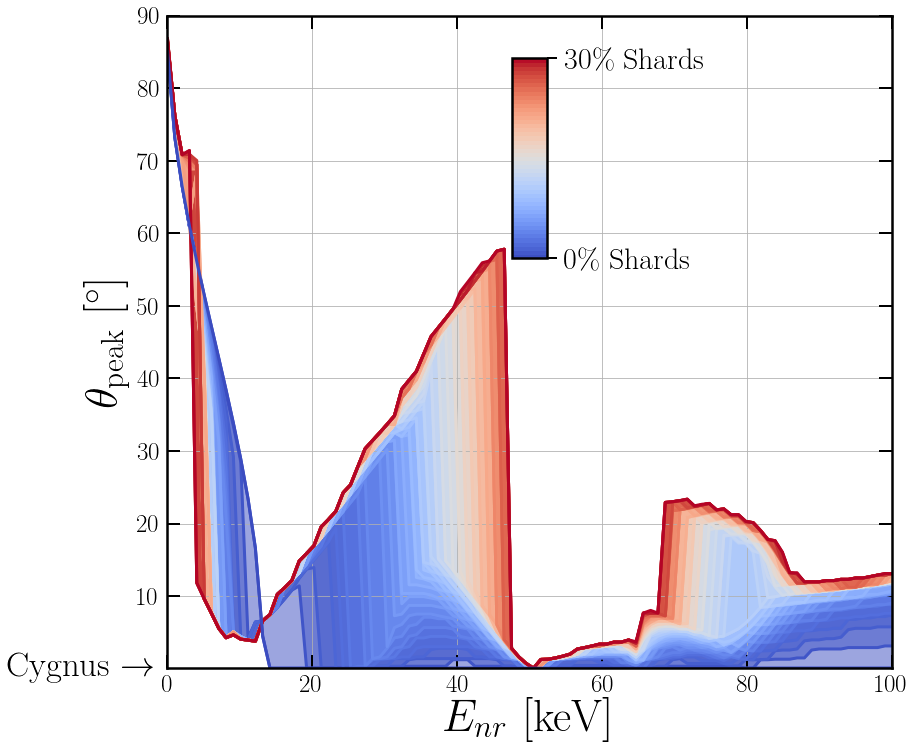

In [74]:
# Figure setup
pltname = 'Shards_peakdirection'

xlab = r"$E_{nr}$ [keV]"
ylab = r"$\theta_{\rm peak}$ [$^\circ$]"
fig,ax = MySquarePlot(xlab,ylab)

col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
for j in range(0,n_xi):
    plt.fill_between(Evals,dth[:,j],y2=dth[:,-1],color=col[j,:],alpha=0.5)
    plt.plot(Evals,dth[:,j],'-',color=col[j,:],linewidth=3)

plt.plot(Evals,dth0,linewidth=3,color=col[0,:])
plt.ylim([0.1,90])
plt.xlim([0,amax(Evals)])
plt.text(-22,-1,r'Cygnus $\rightarrow$',fontsize=35)
plt.grid()

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels(['0\% Shards', '30\% Shards'])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [75]:
# Figure setup
from mpl_toolkits.basemap import shiftgrid


# Set up binning
n = 100
ph = flipud(linspace(-pi, pi-2*pi/n, n))
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1
        
def convertmap(fv3D):
    fv_map = zeros(shape=(n/2,n))
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    return fv_map

# v binning
nv = 1000
v_vals = linspace(0.1,600,nv)

# Smooth
fv3D_Saus = zeros(shape=n*n/2)
fv3D_Iso = zeros(shape=n*n/2)
for j in range(0,nv):
    fv3D_Iso += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_iso)
    fv3D_Saus += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_beta)
    
# Shards
fv_map_shards = zeros(shape=(n/2,n,nshards))
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    x_str = v_str/sqrt(sum(v_str**2.0))
    sig_s = dispersions[isub,:]
    fv3D = zeros(shape=(n*n/2))
    for j in range(0,nv):
        fv3D += v_vals[j]*weights[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_str)
    print isub

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0 0.0

IndexError: invalid index to scalar variable.

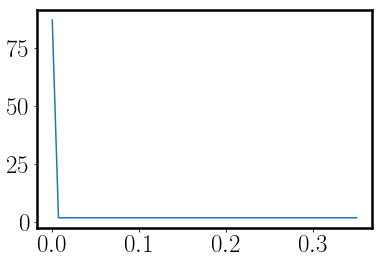

In [87]:
eta = 0.2
n_xi = 50
xi_vals = linspace(0,0.35,n_xi)
dth = zeros(shape=n_xi)
qmin = zeros(shape=(n_xi,3))
for i in range(0,n_xi):
    xi = xi_vals[i]
    imax = argmax(xi*((1-eta)*fv3D_Iso + eta*fv3D_Saus) + xi*fv3D)
    qmin[i,:] = q[imax,:]
    dth[i] = (180/pi)*arccos(sum(-1.0*qmin[i,:]*x_lab))
    
plt.plot(xi_vals,dth)
plt.show()

In [90]:
velocities

array([[  -8.61301201, -286.74421986,  -67.90416504],
       [   0.51735825,  160.83571554, -230.994398  ],
       [ -70.93407008,  153.26857936,  161.54080752],
       [-242.42905844,  109.856005  ,  180.72578157],
       [  54.07745034, -393.7677355 ,   68.31781118],
       [  47.80520935, -254.54847547,   71.78301129],
       [-222.65511814, -234.79077191,  -97.89473231],
       [ 141.90901162, -293.39830539,   70.65916881],
       [ 177.63662538, -287.90816705,  117.87824923],
       [  -9.99854228,  -82.28254446,   -0.56443163],
       [ -11.94200057, -222.10328712,   88.03480928],
       [-288.74653232, -158.13483051, -105.47447765],
       [ 261.37566133, -163.88450384,   96.31963348],
       [   8.2410844 ,  192.00679219,  -25.01197059],
       [  48.42756082,  164.54419364, -171.138794  ],
       [-115.6166536 ,   17.40287755,  169.3060401 ],
       [ -82.80853031,   91.69589744,   41.39632949],
       [ -33.27733204,   94.41283077,   60.91014055],
       [-101.35227808,   -9.

In [91]:
weights

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.202020
5     0.000000
6     0.050505
7     0.000000
8     0.131313
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.040404
28    0.000000
29    0.101010
        ...   
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.090909
48    0.040404
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.000000
58    0.000000
59    0.101010
60    0.000000
61    0.000000
62    0.000000
63    0.000000
64    0.000000
65    0.000000
66    0.000000
67    0.000000
Length: 68, dtype: float64